In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 32s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [22]:
training_data_df['토지면적over총연면적times공시지가'] = training_data_df['토지면적'] / training_data_df['총연면적'] * training_data_df['공시지가(만원)']

In [24]:
new_feature = ['토지면적over총연면적times공시지가']

In [27]:
shap_summary_df = pd.read_csv(basedir + 'shap_top_41.csv', index_col=[0]).sort_values(['shap_summary_mean'], ascending=False)
print(shap_summary_df.shape)
shap_summary_df.head()

(41, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.058814,93.599680,90.010205,94.337450,95.602837,93.321797
공시지가(만원),75.770672,77.786150,79.246323,75.407583,79.580994,77.558344
year_linear,63.010370,63.152728,64.733163,63.441504,64.620357,63.791624
건축년도,46.003550,50.425418,47.711136,49.073639,48.231282,48.289005
전용면적,37.853278,37.105692,38.188654,39.627534,40.736178,38.702267


In [28]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.058814,93.599680,90.010205,94.337450,95.602837,93.321797
공시지가(만원),75.770672,77.786150,79.246323,75.407583,79.580994,77.558344
year_linear,63.010370,63.152728,64.733163,63.441504,64.620357,63.791624
건축년도,46.003550,50.425418,47.711136,49.073639,48.231282,48.289005
전용면적,37.853278,37.105692,38.188654,39.627534,40.736178,38.702267
ynorm,30.586887,30.520965,32.265034,29.938875,31.734174,31.009187
xy,22.010398,21.302770,20.232423,21.212108,21.167733,21.185086
x_2nd,18.967359,18.208714,18.728190,20.188932,19.567873,19.132214
주건축물수,14.245127,12.391786,13.432620,13.348851,14.085138,13.500704
층mean,11.179779,11.650586,10.523600,12.048457,10.518641,11.184212


In [29]:
top_40_df = shap_summary_df.iloc[:40,:]
print(top_40_df.shape)

(40, 6)


In [30]:
top_40_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.058814,93.599680,90.010205,94.337450,95.602837,93.321797
공시지가(만원),75.770672,77.786150,79.246323,75.407583,79.580994,77.558344
year_linear,63.010370,63.152728,64.733163,63.441504,64.620357,63.791624
건축년도,46.003550,50.425418,47.711136,49.073639,48.231282,48.289005
전용면적,37.853278,37.105692,38.188654,39.627534,40.736178,38.702267


In [31]:
top_40_df.tail(20)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
호수대비주차수,4.887116,5.152687,5.223793,4.905114,5.251574,5.084057
용도지역명1,3.938025,4.640084,4.673148,4.521006,4.289242,4.412301
층norm,3.956640,3.982508,3.876024,3.974704,3.929386,3.943853
지구단위계획구역,2.907496,3.147528,2.981508,3.109891,3.742334,3.177751
부속건축물수,2.783065,2.912021,3.325954,2.557020,2.040603,2.723733
도로접면,2.645609,2.859477,2.750651,2.705742,2.652331,2.722762
가축사육제한구역,2.354782,2.594802,2.617098,2.534347,2.861789,2.592564
부속건축물면적,2.605777,1.908232,2.887277,2.647562,2.443426,2.498455
지붕_평지붕_fraction,2.412876,2.396083,2.319576,2.404824,2.614754,2.429623
공원,2.471808,2.577535,2.286046,2.264480,2.081741,2.336322


In [32]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [34]:
training_data_df = training_data_df[top_40_df.index.tolist()+new_feature+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 46)


,trade_type,공시지가(만원),year_linear,건축년도,전용면적,ynorm,xy,x_2nd,주건축물수,층mean,총건축면적,토지이동상황,호수대비연면적,아파트지구,xnorm,호수대비부속건축물면적,옥내자주식대수,y_2nd,층,총호수,호수대비주차수,용도지역명1,층norm,지구단위계획구역,부속건축물수,도로접면,가축사육제한구역,부속건축물면적,지붕_평지붕_fraction,공원,지형높이,(한강)폐기물매립시설_설치제한지역,건물나이,옥외자주식대수,층min,month_sin,x_sin,지형형상,y_sin,y_cos,토지면적over총연면적times공시지가,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,0,5579.095707,0.0,0.0,4.094180e+07,2,54.0,0.0,0,0.222222,0,0.0,0,0,0.0,1.0,0,0,0,0,0.0,9.0,-0.866025,-0.364267,0,-0.920469,0.390815,758.319895,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,921.0,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,0,5579.095707,0.0,0.0,4.094180e+07,2,54.0,0.0,0,0.222222,0,0.0,0,0,0.0,1.0,0,0,0,0,0.0,9.0,-0.500000,-0.364267,0,-0.920469,0.390815,758.319895,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,921.0,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,0,5579.095707,0.0,0.0,4.094180e+07,4,54.0,0.0,0,0.444444,0,0.0,0,0,0.0,1.0,0,0,0,0,0.0,9.0,0.000000,-0.364267,0,-0.920469,0.390815,758.319895,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,921.0,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,0,5579.095707,0.0,0.0,4.094180e+07,9,54.0,0.0,0,1.000000,0,0.0,0,0,0.0,1.0,0,0,0,0,0.0,9.0,0.866025,-0.364267,0,-0.920469,0.390815,758.319895,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,0,5579.095707,0.0,0.0,4.094180e+07,1,54.0,0.0,0,0.111111,0,0.0,0,0,0.0,1.0,0,0,0,0,0.0,9.0,-0.866025,-0.364267,0,-0.920469,0.390815,758.319895,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [35]:
from sklearn.model_selection import KFold, GroupKFold

In [36]:
import lightgbm as lgb

In [37]:
from sklearn.metrics import r2_score

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [39]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

12

In [40]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 41)
y dist plot


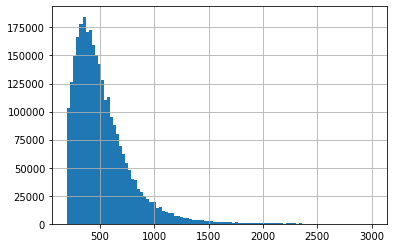

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5915
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 41


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.3353
[100]	valid_0's huber: 64.8394
[150]	valid_0's huber: 58.6875
[200]	valid_0's huber: 55.0266
[250]	valid_0's huber: 52.6016
[300]	valid_0's huber: 50.8727
[350]	valid_0's huber: 49.5997
[400]	valid_0's huber: 48.5486
[450]	valid_0's huber: 47.596
[500]	valid_0's huber: 46.7426
[550]	valid_0's huber: 45.9377
[600]	valid_0's huber: 45.3681
[650]	valid_0's huber: 44.8861
[700]	valid_0's huber: 44.3623
[750]	valid_0's huber: 43.8713
[800]	valid_0's huber: 43.4174
[850]	valid_0's huber: 43.0304
[900]	valid_0's huber: 42.6473
[950]	valid_0's huber: 42.2887
[1000]	valid_0's huber: 41.9476
[1050]	valid_0's huber: 41.6364
[1100]	valid_0's huber: 41.361
[1150]	valid_0's huber: 41.1129
[1200]	valid_0's huber: 40.862
[1250]	valid_0's huber: 40.6516
[1300]	valid_0's huber: 40.4334
[1350]	valid_0's huber: 40.2285
[1400]	valid_0's huber: 40.0469
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


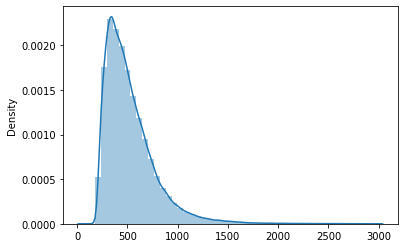

Fold 0 end
Fold 1 start
(2926581, 41)
y dist plot


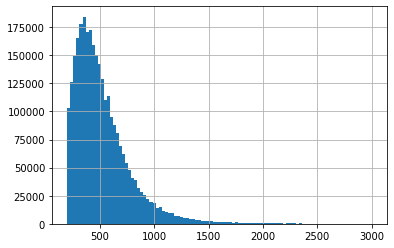

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5916
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 41


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6562
[100]	valid_0's huber: 64.8714
[150]	valid_0's huber: 58.7029
[200]	valid_0's huber: 54.9736
[250]	valid_0's huber: 52.4088
[300]	valid_0's huber: 50.7531
[350]	valid_0's huber: 49.4491
[400]	valid_0's huber: 48.308
[450]	valid_0's huber: 47.3454
[500]	valid_0's huber: 46.5506
[550]	valid_0's huber: 45.9939
[600]	valid_0's huber: 45.3147
[650]	valid_0's huber: 44.775
[700]	valid_0's huber: 44.2497
[750]	valid_0's huber: 43.7773
[800]	valid_0's huber: 43.4106
[850]	valid_0's huber: 42.9758
[900]	valid_0's huber: 42.6456
[950]	valid_0's huber: 42.2619
[1000]	valid_0's huber: 41.9312
[1050]	valid_0's huber: 41.6349
[1100]	valid_0's huber: 41.334
[1150]	valid_0's huber: 41.0584
[1200]	valid_0's huber: 40.827
[1250]	valid_0's huber: 40.5922
[1300]	valid_0's huber: 40.3713
[1350]	valid_0's huber: 40.1985
[1400]	valid_0's huber: 40.0165
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


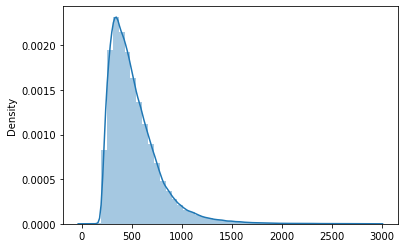

Fold 1 end
Fold 2 start
(2926581, 41)
y dist plot


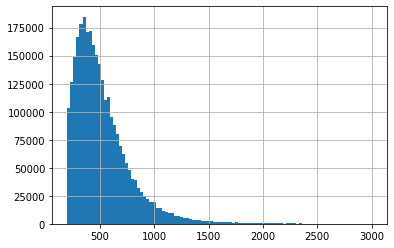

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 41


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.3731
[100]	valid_0's huber: 64.7792
[150]	valid_0's huber: 58.6178
[200]	valid_0's huber: 54.9491
[250]	valid_0's huber: 52.5378
[300]	valid_0's huber: 50.7422
[350]	valid_0's huber: 49.5026
[400]	valid_0's huber: 48.2967
[450]	valid_0's huber: 47.3579
[500]	valid_0's huber: 46.5515
[550]	valid_0's huber: 45.7906
[600]	valid_0's huber: 45.1773
[650]	valid_0's huber: 44.6003
[700]	valid_0's huber: 44.11
[750]	valid_0's huber: 43.6542
[800]	valid_0's huber: 43.2078
[850]	valid_0's huber: 42.796
[900]	valid_0's huber: 42.4414
[950]	valid_0's huber: 42.1201
[1000]	valid_0's huber: 41.8333
[1050]	valid_0's huber: 41.5465
[1100]	valid_0's huber: 41.3137
[1150]	valid_0's huber: 41.0659
[1200]	valid_0's huber: 40.8359
[1250]	valid_0's huber: 40.6035
[1300]	valid_0's huber: 40.4026
[1350]	valid_0's huber: 40.2043
[1400]	valid_0's huber: 40.0188
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


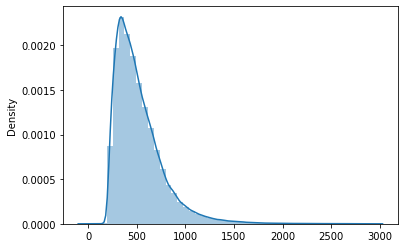

Fold 2 end
Fold 3 start
(2926581, 41)
y dist plot


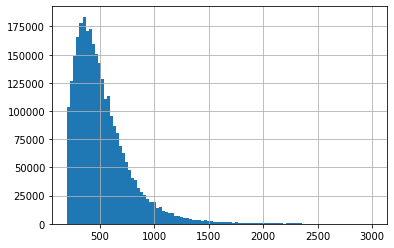

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5912
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 41


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4102
[100]	valid_0's huber: 64.8632
[150]	valid_0's huber: 58.6307
[200]	valid_0's huber: 54.9939
[250]	valid_0's huber: 52.6074
[300]	valid_0's huber: 50.8112
[350]	valid_0's huber: 49.524
[400]	valid_0's huber: 48.3636
[450]	valid_0's huber: 47.5352
[500]	valid_0's huber: 46.7002
[550]	valid_0's huber: 45.978
[600]	valid_0's huber: 45.3375
[650]	valid_0's huber: 44.739
[700]	valid_0's huber: 44.1786
[750]	valid_0's huber: 43.7731
[800]	valid_0's huber: 43.3687
[850]	valid_0's huber: 42.9613
[900]	valid_0's huber: 42.5823
[950]	valid_0's huber: 42.256
[1000]	valid_0's huber: 41.9566
[1050]	valid_0's huber: 41.6492
[1100]	valid_0's huber: 41.3505
[1150]	valid_0's huber: 41.1068
[1200]	valid_0's huber: 40.8555
[1250]	valid_0's huber: 40.6592
[1300]	valid_0's huber: 40.4341
[1350]	valid_0's huber: 40.2348
[1400]	valid_0's huber: 40.0589
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


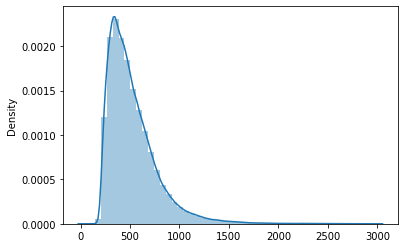

Fold 3 end
Fold 4 start
(2926581, 41)
y dist plot


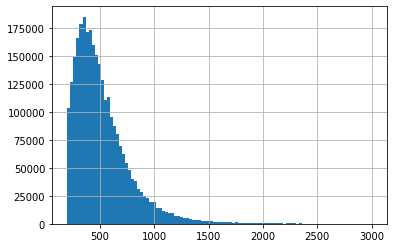

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5913
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 41


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.392
[100]	valid_0's huber: 64.9295
[150]	valid_0's huber: 58.7542
[200]	valid_0's huber: 55.1843
[250]	valid_0's huber: 52.6656
[300]	valid_0's huber: 50.9307
[350]	valid_0's huber: 49.5958
[400]	valid_0's huber: 48.4729
[450]	valid_0's huber: 47.5841
[500]	valid_0's huber: 46.8456
[550]	valid_0's huber: 46.0614
[600]	valid_0's huber: 45.3488
[650]	valid_0's huber: 44.8038
[700]	valid_0's huber: 44.3716
[750]	valid_0's huber: 43.9058
[800]	valid_0's huber: 43.4632
[850]	valid_0's huber: 43.0439
[900]	valid_0's huber: 42.6598
[950]	valid_0's huber: 42.3172
[1000]	valid_0's huber: 41.9959
[1050]	valid_0's huber: 41.7156
[1100]	valid_0's huber: 41.4421
[1150]	valid_0's huber: 41.1759
[1200]	valid_0's huber: 40.9088
[1250]	valid_0's huber: 40.7038
[1300]	valid_0's huber: 40.4921
[1350]	valid_0's huber: 40.3189
[1400]	valid_0's huber: 40.1383
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


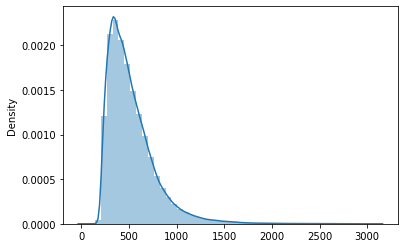

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [41]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_41_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[sample_x.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [42]:
from sklearn.metrics import mean_squared_error

In [43]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

65.67470746772656

In [44]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [45]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [46]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [47]:
shap_summary_df.index = x_train.columns

In [48]:
shap_summary_df.to_csv(basedir + 'shap_top_41.csv')

In [52]:
shap_summary_df = shap_summary_df.sort_values(['shap_summary_mean'], ascending=False)

In [53]:
shap_summary_df.head(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.147825,98.089536,92.713554,93.029416,93.949019,94.185870
year_linear,64.603044,63.698313,60.974000,59.655577,63.596718,62.505530
건축년도,47.726481,50.692866,47.562172,47.629724,46.498284,48.021905
토지면적over총연면적times공시지가,48.094318,48.912633,50.072332,47.278399,43.209724,47.513481
전용면적,39.749002,38.479572,38.669571,36.775456,36.259120,37.986544
공시지가(만원),32.851946,33.442776,29.855805,35.276999,35.018136,33.289132
ynorm,32.673097,31.135935,30.122760,30.297247,31.882861,31.222380
xy,21.013461,23.257674,21.961139,21.737328,21.815612,21.957043
x_2nd,18.299450,19.844998,19.063680,19.325411,17.200163,18.746740
주건축물수,12.330015,11.776492,10.717723,11.207511,12.626433,11.731635


In [54]:
shap_summary_df.tail(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
층min,2.027212,2.324173,2.533052,2.159245,2.350489,2.278834
건물나이,2.003826,2.156561,2.273839,2.413933,2.307219,2.231076
month_sin,2.013315,2.376435,2.191701,2.326877,2.104950,2.202655
옥외자주식대수,2.356791,2.212900,2.230205,1.945991,2.046048,2.158387
(한강)폐기물매립시설_설치제한지역,2.048780,2.055872,2.157592,1.917833,1.856588,2.007333
공원,2.012106,1.355222,1.425212,1.443999,1.612934,1.569895
지형형상,1.499669,1.516375,1.271674,1.357677,1.501698,1.429419
x_sin,1.552792,1.381164,1.522489,1.280322,1.261609,1.399675
y_sin,1.405158,1.352246,1.201998,1.357584,1.314112,1.326220
y_cos,1.471721,1.286668,1.173599,1.271852,1.262533,1.293275
